In [166]:
# adapted version of https://www.kaggle.com/cbrogan/titanic/xgboost-example-python/code
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
%matplotlib inline

In [167]:
# Load the data
train_df = pd.read_csv('../data/train.csv', header=0)
test_df = pd.read_csv('../data/test.csv', header=0)
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [168]:
train_df['Intact'], train_df['Sex'] = train_df.SexuponOutcome.str.split(' ').str
train_df['Intact'] = train_df['Intact'].replace('Unknown', np.nan)
train_df['Intact'] = train_df['Intact'].replace('Spayed', 'Neutered')

test_df['Intact'], test_df['Sex'] = test_df.SexuponOutcome.str.split(' ').str
test_df['Intact'] = test_df['Intact'].replace('Unknown', np.nan)


train_df[5:10]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Sex
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan,Intact,Female
6,A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby,Intact,Male
7,A701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby,NaN,NaN
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,Neutered,Female
9,A677747,NaN,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White,Neutered,Female


Split `SexuponOutcome` into `Intact` and `Sex`

In [169]:
# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.
# This is based on some nice code by 'sveitser' at http://stackoverflow.com/a/25562948
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

# feature_columns_to_use = ['AnimalType', 'Sex', 'Intact', 'Breed']
feature_columns_to_use = ['AnimalType', 'SexuponOutcome', 'Breed']

nonnumeric_columns = feature_columns_to_use

# Join the features from train and test together before imputing missing values,
# in case their distribution is slightly different
# Do we really wanna do this? S/b said this is bad practice for some reason
big_X = train_df[feature_columns_to_use].append(test_df[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)
big_X_imputed[5:10]

,AnimalType,SexuponOutcome,Breed
5,Dog,Intact Female,Cairn Terrier/Chihuahua Shorthair
6,Cat,Intact Male,Domestic Shorthair Mix
7,Cat,Unknown,Domestic Shorthair Mix
8,Dog,Spayed Female,American Pit Bull Terrier Mix
9,Dog,Spayed Female,Cairn Terrier


Fill in missing fields:
* `mean` if column is numeric
* `most common value` if not numeric

In [170]:
# See http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing for more
# details and options
le = LabelEncoder()
for feature in nonnumeric_columns:
    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

# Prepare the inputs for the model
train_X = big_X_imputed[0:train_df.shape[0]].as_matrix()
test_X = big_X_imputed[train_df.shape[0]::].as_matrix()
train_df.OutcomeType = le.fit_transform(train_df.OutcomeType)
train_y = train_df['OutcomeType']

## Parameters
Some information about parameter tweaking: [click](http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

### Objective
Set against which loss function the algorithm should minimize. What we need: Multiclass with probabilities. So we choose `multi:softprob`. This in return needs a parameter `num_class` which indicates the number of differenct classes. In our case thats the number of distinct values for cloumn `OutcomeType`

In [171]:
# right know these values fall from the sky. No idea what they mean. Needs investigation
param = {
    'objective': 'multi:softprob',
    'num_class': train_df.OutcomeType.nunique(),  # should be 5
    'eta': 0.05,
    'max_depth': 8,
    'min_child_weight': 8,
    'silent': 1,
    'seed':1,
    'subsample': 0.5,
#     'colsample_bytree' : 0.5,
    'alpha' : 4,
#     'eval_metric' : 'auc',

}

## Do the actual learning

In [172]:
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.01, random_state=10)

`train_test_split` is a shorthand to randomly split a training set into train/test data for cross validation. 

* `test_size`: sets the percentage of data used for the test set.
* `random_state`: is used to get reproducible randomness

In [173]:
xgmat = xgb.DMatrix(X_train, label=y_train)  # cross validation training set
xgmat_valid = xgb.DMatrix(X_valid, label=y_valid)  # cross validation test set
xgmat_test = xgb.DMatrix(test_X)  # the original test set from kaggle

transforms our generated cross validation data to a format readable by `xgboost`

In [174]:
num_round=1000
watchlist = [(xgmat, 'train'), (xgmat_valid, 'eval')]
gbm = xgb.train(param, xgmat, num_round, watchlist, early_stopping_rounds=50)

Will train until train error hasn't decreased in 50 rounds.
[0]	eval-merror:0.432836	train-merror:0.390726
[1]	eval-merror:0.425373	train-merror:0.390726
[2]	eval-merror:0.425373	train-merror:0.391822
[3]	eval-merror:0.425373	train-merror:0.391822
[4]	eval-merror:0.425373	train-merror:0.390688
[5]	eval-merror:0.425373	train-merror:0.390613
[6]	eval-merror:0.425373	train-merror:0.390688
[7]	eval-merror:0.425373	train-merror:0.390688
[8]	eval-merror:0.425373	train-merror:0.390688
[9]	eval-merror:0.425373	train-merror:0.390688
[10]	eval-merror:0.425373	train-merror:0.390688
[11]	eval-merror:0.425373	train-merror:0.390688
[12]	eval-merror:0.425373	train-merror:0.390688
[13]	eval-merror:0.425373	train-merror:0.390915
[14]	eval-merror:0.425373	train-merror:0.390915
[15]	eval-merror:0.425373	train-merror:0.390915
[16]	eval-merror:0.425373	train-merror:0.390915
[17]	eval-merror:0.425373	train-merror:0.390613
[18]	eval-merror:0.425373	train-merror:0.390499
[19]	eval-merror:0.425373	train-merror

We don't just simply learn a model but we observe how the precision evolves [more info](http://xgboost.readthedocs.io/en/latest/python/python_intro.html#training)
* `early_stopping_rounds`: will stop training if the precision did not improve in the set number of rounds
* `watchlist`: contains the parameters to watch while learning

__*train() only returns the last model, not necessarily the best one!*__  see [here](http://xgboost.readthedocs.io/en/latest/python/python_intro.html#prediction)

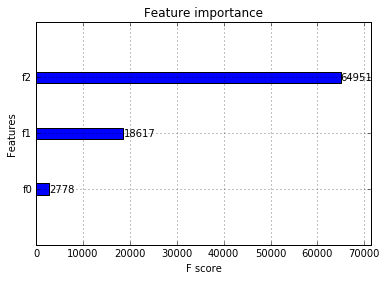

In [180]:
xgb.plot_importance(gbm)

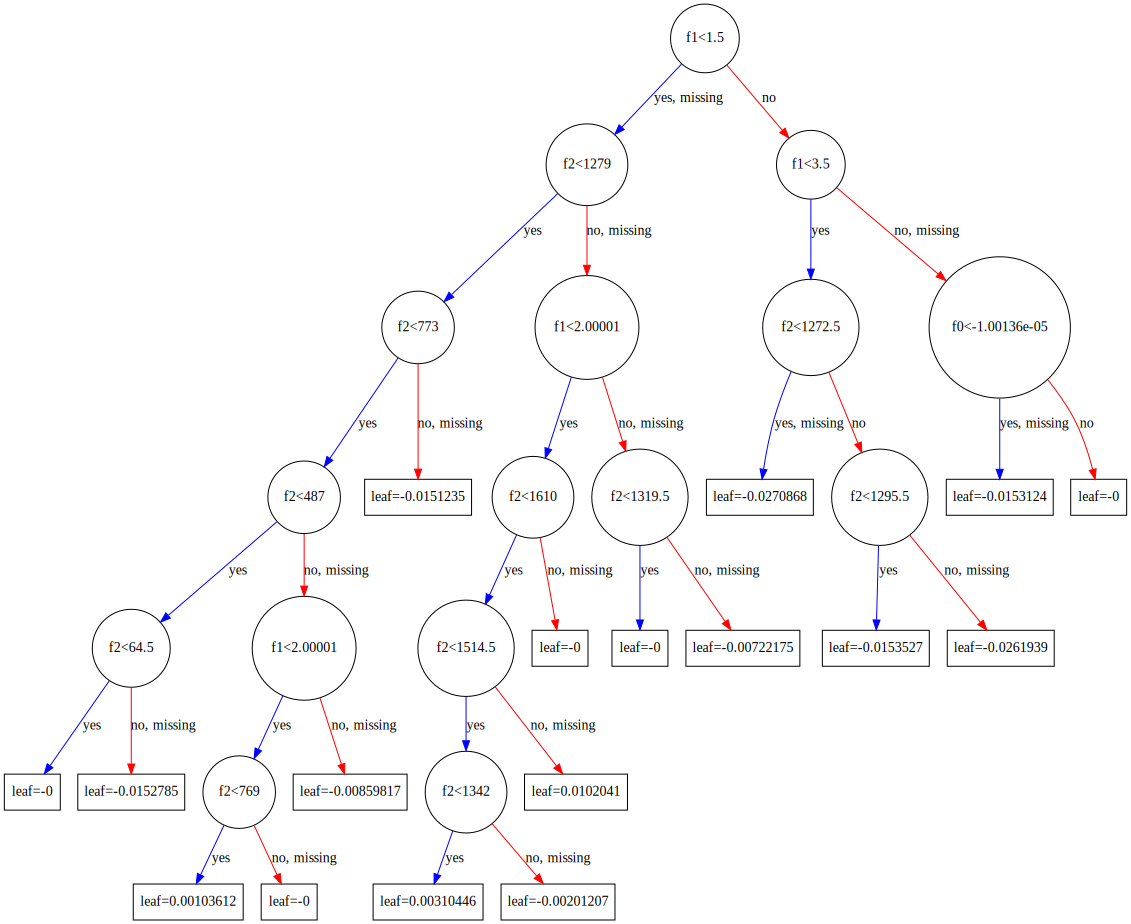

In [176]:
xgb.to_graphviz(gbm, num_trees=2)  # needs graphviz: 'sudo apt-get install graphviz' and 'pip3 install graphviz'

## Predict and save as Kaggel

In [181]:
predictions = gbm.predict(xgmat_test)

predictions

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


array([[ 0.03644392,  0.01003186,  0.09729161,  0.13014783,  0.72608471],
       [ 0.60599786,  0.00162836,  0.01489239,  0.28106377,  0.09641759],
       [ 0.66047633,  0.00274555,  0.03010001,  0.07398523,  0.23269285],
       ..., 
       [ 0.06704083,  0.0170158 ,  0.08921267,  0.00642016,  0.82031053],
       [ 0.51136798,  0.00165575,  0.02938269,  0.33230123,  0.12529236],
       [ 0.0417625 ,  0.00911167,  0.07253075,  0.3526268 ,  0.52396828]], dtype=float32)

In [183]:
# to kaggle format
submission_df = pd.DataFrame(predictions)
submission_df = pd.concat([test_df.ID, submission_df], axis=1)
submission_df.ID = submission_df.ID.astype(int)
submission_df.set_index('ID', inplace=True)
submission_df.columns = le.inverse_transform(sorted(train_df.OutcomeType.unique()))  # get the string labels back
submission_df.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
ID,,,,,
1,0.036444,0.010032,0.097292,0.130148,0.726085
2,0.605998,0.001628,0.014892,0.281064,0.096418
3,0.660476,0.002746,0.030100,0.073985,0.232693
4,0.047108,0.008592,0.174650,0.250332,0.519318
5,0.519301,0.001370,0.007359,0.279508,0.192463


In [ ]:
submission_df.to_csv('submission2.csv')
len(submission_df)